# Classificação de texto com TensorFlow

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import stopwordsiso as stopwords

import re
import pickle

### Obtendo e preparando os dados

In [2]:
class EncodeTargets():
  TARGETS = [
            "contrato",
            "inadimplemento",
            "constituicao_mora",
            "alienacao_fiduciaria",
            "contrato_alienacao_fiduciaria",
            "inadimplemento_constituicao_mora",
            "outros",
  ]

  @staticmethod
  def predict(label):
    for i, v in enumerate(EncodeTargets.TARGETS):
      if label == v:
        return i
    else:
      return None

  @staticmethod
  def inverse(index):
    return EncodeTargets.TARGETS[index]

In [5]:
DATA_SET_FILE = "../dataset/data.v1.csv"

df = pd.read_csv(DATA_SET_FILE, 
                 usecols=["label", "text"]).drop_duplicates(subset=['text']).sample(frac=1)

df["label_"] = df["label"].apply(lambda l: EncodeTargets.predict(l))
df["text_"] = df["text"].apply(lambda t: t)

print("----------------")
print(f"Shape: {df.shape}")

df.head(10)

----------------
Shape: (3183, 4)


,label,text,label_,text_
2174,alienacao_fiduciaria,Como garantia das obrigações contratadas a RÉ ...,3,Como garantia das obrigações contratadas a RÉ ...
2055,outros,Nestes termos.,6,Nestes termos.
3694,inadimplemento_constituicao_mora,"Contudo, a parte requerida deixou de adimplir ...",5,"Contudo, a parte requerida deixou de adimplir ..."
2966,alienacao_fiduciaria,Em decorrência do contrato firmado entre as pa...,3,Em decorrência do contrato firmado entre as pa...
1880,constituicao_mora,"Insta salientar que, por diversas vezes tentou...",2,"Insta salientar que, por diversas vezes tentou..."
193,alienacao_fiduciaria,2. Em garantia das obrigações assumidas a ré (...,3,2. Em garantia das obrigações assumidas a ré (...
1004,constituicao_mora,"Nessa linha, ante o inadimplemento e comprovad...",2,"Nessa linha, ante o inadimplemento e comprovad..."
1841,inadimplemento,"3. Ocorre, porém, que o réu tornou-se inadimpl...",1,"3. Ocorre, porém, que o réu tornou-se inadimpl..."
248,outros,"5. Assim, o débito vencido do réu, devidamente...",6,"5. Assim, o débito vencido do réu, devidamente..."
628,inadimplemento,"3. Ocorre, porém, que o(a) Réu(Ré) tornou­se I...",1,"3. Ocorre, porém, que o(a) Réu(Ré) tornou­se I..."


In [6]:
sentences = df.text_.values
labels = df.label_.values

In [7]:
train_size = int(0.8 * len(labels))

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(f"Train length: {len(train_sentences)}")
print(f"Test length: {len(validation_sentences)}")

Train length: 2546
Test length: 637


### Tokenizer

Definição dos hiperparâmetros

In [8]:
vocab_size = 10000
embedding_dim = 16
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

A idéia principal de dividir seu conjunto de dados em treinar e teste é avaliar seu modelo performa bem em dados desconhecidos. 
Dito isso, se você ajustar seu tokenizer em um conjunto de dados inteiro, de alguma forma está enviesando seu modelo. Para uma boa avaliação do seu modelo, você deve levar em consideração tokens não conhecidos. Portanto, como qualquer outro tipo de "extração de recursos", as melhores práticas é usar somente os dados de treino.


In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen=max_length)

In [10]:
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

Found 8124 unique tokens.


{'<OOV>': 1,
 'de': 2,
 'e': 3,
 'o': 4,
 'a': 5,
 'em': 6,
 'do': 7,
 'com': 8,
 'da': 9,
 'no': 10}

In [11]:
model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
 tf.keras.layers.GlobalAveragePooling1D(),
 tf.keras.layers.Dense(24, activation='relu'),
 tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 175       
Total params: 160,583
Trainable params: 160,583
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 20

history = model.fit(train_padded, train_labels, 
                    epochs = num_epochs, 
                    validation_data=(validation_padded, validation_labels), 
                    verbose=2)

Epoch 1/20
80/80 - 1s - loss: 1.9067 - accuracy: 0.2482 - val_loss: 1.8592 - val_accuracy: 0.2684
Epoch 2/20
80/80 - 0s - loss: 1.8307 - accuracy: 0.2482 - val_loss: 1.7900 - val_accuracy: 0.2684
Epoch 3/20
80/80 - 0s - loss: 1.7346 - accuracy: 0.2706 - val_loss: 1.6643 - val_accuracy: 0.2983
Epoch 4/20
80/80 - 0s - loss: 1.5504 - accuracy: 0.4556 - val_loss: 1.4319 - val_accuracy: 0.4914
Epoch 5/20
80/80 - 0s - loss: 1.2733 - accuracy: 0.5962 - val_loss: 1.1560 - val_accuracy: 0.6970
Epoch 6/20
80/80 - 0s - loss: 1.0096 - accuracy: 0.7227 - val_loss: 0.9151 - val_accuracy: 0.7535
Epoch 7/20
80/80 - 0s - loss: 0.8028 - accuracy: 0.7577 - val_loss: 0.7298 - val_accuracy: 0.7598
Epoch 8/20
80/80 - 0s - loss: 0.6516 - accuracy: 0.7797 - val_loss: 0.6033 - val_accuracy: 0.7786
Epoch 9/20
80/80 - 0s - loss: 0.5483 - accuracy: 0.8095 - val_loss: 0.5217 - val_accuracy: 0.8053
Epoch 10/20
80/80 - 0s - loss: 0.4740 - accuracy: 0.8429 - val_loss: 0.4625 - val_accuracy: 0.8257
Epoch 11/20
80/80 -

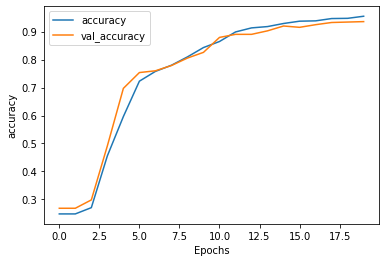

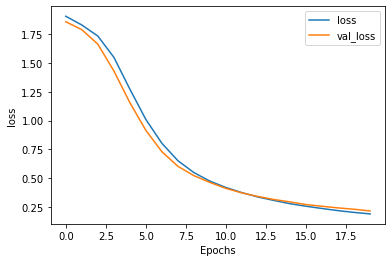

In [13]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
texts = [
"""
3. Ocorre, porém, que o Réu se tornou
inadimplente, deixando de efetuar o pagamento das prestações a partir de 10
de julho de 2018 incorrendo em mora desde então, nos termos do artigo 2o e
§ 2o, do Decreto-Lei 911/69, com as alterações da Lei 13.043/2014.
""",
"""
4. O Autor, seguindo os procedimentos
estabelecidos pela Lei 13.043/2014, constituiu a mora do Réu, por meio da
notificação extrajudicial anexada.
""",
"""
Na data de 11/11/2013, as partes celebraram (Contrato de Financiamento
com Garantia de Alienação Fiduciária/Cédula de Crédito) (d oc. a ne xo
c ontr ato o u c éd u la), sob o no 30410000000569736952 no valor total de
R$ 28.186,08, com pagamento por meio de 48 parcelas mensais e
consecutivas. Tendo como objeto o bem com as seguintes características:

Marca: Volkswagen
Modelo: Gol (G4) (Tf) Plus1.0
Ano: 2008 / 2008
Cor: Cinza
Placa: EAQ8370
RENAVAM:
CHASSI: 9BWAA05W89P032610
""",
"""
A parte Ré, em conformidade com o competente Contrato
de Alienação Fiduciária de Participação em Grupo de Consórcio, obteve junto a
Autora um crédito para aquisição de bens.
"""
]

padded_text = pad_sequences(tokenizer.texts_to_sequences(texts),maxlen=max_length, truncating=trunc_type)

predictotron=model.predict(padded_text)

for item, text in zip(predictotron, texts):
  print("---")
  print(text)
  for index, ele in enumerate(item):
    print(f" {EncodeTargets.inverse(index)} — " + str(round(ele*100,4))+" %")
 

---

3. Ocorre, porém, que o Réu se tornou
inadimplente, deixando de efetuar o pagamento das prestações a partir de 10
de julho de 2018 incorrendo em mora desde então, nos termos do artigo 2o e
§ 2o, do Decreto-Lei 911/69, com as alterações da Lei 13.043/2014.

 contrato — 0.0034 %
 inadimplemento — 93.9835 %
 constituicao_mora — 1.4684 %
 alienacao_fiduciaria — 0.0052 %
 contrato_alienacao_fiduciaria — 0.0 %
 inadimplemento_constituicao_mora — 4.526 %
 outros — 0.0135 %
---

4. O Autor, seguindo os procedimentos
estabelecidos pela Lei 13.043/2014, constituiu a mora do Réu, por meio da
notificação extrajudicial anexada.

 contrato — 3.3074 %
 inadimplemento — 9.7017 %
 constituicao_mora — 61.3512 %
 alienacao_fiduciaria — 5.3374 %
 contrato_alienacao_fiduciaria — 0.792 %
 inadimplemento_constituicao_mora — 3.9786 %
 outros — 15.5317 %
---

Na data de 11/11/2013, as partes celebraram (Contrato de Financiamento
com Garantia de Alienação Fiduciária/Cédula de Crédito) (d oc. a ne xo
c ontr

### Save the Model

In [19]:
model_dir = "../app/model"
model_bin = f"{model_dir}/model.bin"

model.save(model_dir)

data = (tokenizer,)
with open(model_bin,'wb') as f:
  pickle.dump(data, f)

INFO:tensorflow:Assets written to: ../app/model/assets


In [20]:
r_model = tf.keras.models.load_model(model_dir)

with open(model_bin,'rb') as f:
  r_tokenizer, = pickle.load(f)

In [22]:
text = """
A parte Ré, em conformidade com o competente Contrato
de Alienação Fiduciária de Participação em Grupo de Consórcio, obteve junto a
Autora um crédito para aquisição de bens.
"""

padded_text = pad_sequences(r_tokenizer.texts_to_sequences([text]), maxlen=max_length, truncating=trunc_type)

predict = r_model.predict(padded_text)

for index, ele in enumerate(predict[0]):
    print(f" {index} — {ele}")

 0 — 0.6677758693695068
 1 — 0.009144342504441738
 2 — 0.174580916762352
 3 — 0.003752762218937278
 4 — 0.03268261253833771
 5 — 0.044639572501182556
 6 — 0.0674239993095398
